In [1]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
data_dir = 'data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(80),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(82),
                                         transforms.CenterCrop(80),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=8)

In [4]:
train_loader

In [5]:
# Build and train your network
# Transfer Learning
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(4096, 2)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [32]:
# Function for the validation pass
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()
        print(output)
        probabilities = torch.exp(output)
        print(labels.data)
        print(probabilities.max(dim=1))
        print(probabilities.max(dim=1)[1])
        print(probabilities)
        
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        print(equality)
        print(accuracy)
    
    #return val_loss, accuracy, equality, probabilities

validation(model, test_loader, criterion)

tensor([[ 0.0000e+00, -3.6206e+01],
        [ 0.0000e+00, -4.7785e+01],
        [ 0.0000e+00, -3.3293e+01],
        [-1.4228e+02,  0.0000e+00],
        [ 0.0000e+00, -8.2525e+01],
        [-4.1389e-04, -7.7903e+00],
        [ 0.0000e+00, -1.3741e+02],
        [ 0.0000e+00, -1.5410e+02]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0'))
tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
tensor([[1.0000e+00, 1.8869e-16],
        [1.0000e+00, 1.7671e-21],
        [1.0000e+00, 3.4761e-15],
        [0.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.4445e-36],
        [9.9959e-01, 4.1372e-04],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00]], device='cuda:0', grad_fn=<ExpBackward>)
tensor([ True,  True,  True, Fal

In [15]:
# Loss function and gradient descent

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [16]:
# Train the classifier
train_loss, test_loss = [], []
def train_classifier():
        epochs = 5
        steps = 0
        print_every = 40

        model.to('cuda')

        for e in range(epochs):
        
            model.train()
    
            running_loss = 0
    
            for images, labels in iter(train_loader):
        
                steps += 1
        
                images, labels = images.to('cuda'), labels.to('cuda')
        
                optimizer.zero_grad()
        
                output = model.forward(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                if steps % print_every == 0:
                
                    model.eval()
                
                    # Turn off gradients for validation, saves memory and computations
                    with torch.no_grad():
                        validation_loss, accuracy, equality, probabilities = validation(model, test_loader, criterion)
                        train_loss.append(running_loss/len(train_loader))
                        test_loss.append(validation_loss/len(test_loader))
                        print("Val loss from the function:", validation_loss)
                        print("Accuracy from the function:", accuracy)
                        print("Equality from the function:", equality)
                        print("Probabilities from the function:", probabilities)
                    print("Length of test_loader after eval :", len(test_loader))    
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss/len(test_loader)),
                          "Validation Accuracy: {:.3f}".format(accuracy/len(test_loader)))
            
                    running_loss = 0
                    model.train()
                    
train_classifier()

Val loss from the function: 95.85068321228027
Accuracy from the function: tensor(34.)
Equality from the function: tensor([True], device='cuda:0')
Probabilities from the function: tensor([[0., 1.]], device='cuda:0')
Length of test_loader after eval : 35
Epoch: 1/5..  Training Loss: 2.885..  Validation Loss: 2.739..  Validation Accuracy: 0.971
Val loss from the function: 35.61158275604248
Accuracy from the function: tensor(34.3750)
Equality from the function: tensor([True], device='cuda:0')
Probabilities from the function: tensor([[0., 1.]], device='cuda:0')
Length of test_loader after eval : 35
Epoch: 1/5..  Training Loss: 1.465..  Validation Loss: 1.017..  Validation Accuracy: 0.982
Val loss from the function: 75.91586637496948
Accuracy from the function: tensor(34.2500)
Equality from the function: tensor([True], device='cuda:0')
Probabilities from the function: tensor([[0., 1.]], device='cuda:0')
Length of test_loader after eval : 35
Epoch: 1/5..  Training Loss: 5.518..  Validation Lo

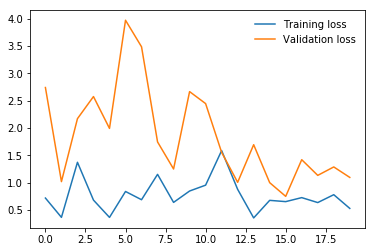

In [20]:
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()